
Found 5592 images belonging to 5 classes.
Found 2396 images belonging to 5 classes.
Class names: ['AmericanBashkirCurly', 'AmericanPaintHorse', 'BelgianDraft', 'Friesian', 'ShetlandPony']


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                               

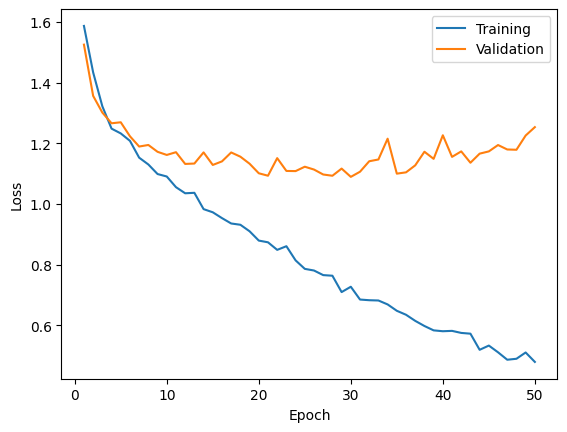

c:\Users\jeanp\OneDrive\Desktop\Thesis Environment\ipcv-env\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved as models/horses2.h5
7/7 [==============================] - 1s 101ms/step


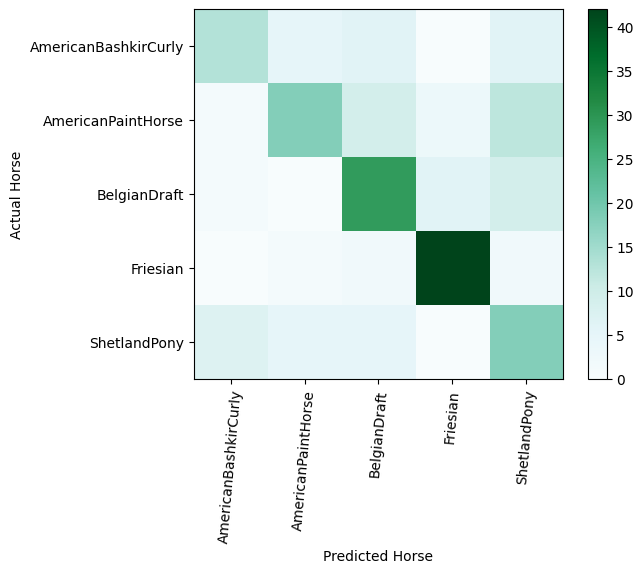

1/1 [==============================] - 0s 23ms/step
Prediction for ABC1.jpg: [[9.9830282e-01 1.7915737e-04 1.3610045e-03 1.5205250e-04 5.0465442e-06]] Class: AmericanBashkirCurly
Prediction for ABC2.jpg: [[8.1602347e-01 1.4331840e-05 3.3468060e-02 5.8632223e-03 1.4463098e-01]] Class: AmericanBashkirCurly
Prediction for ABC3.jpg: [[6.9521165e-01 3.2857777e-08 3.0441779e-01 3.0010885e-09 3.7050288e-04]] Class: AmericanBashkirCurly
Prediction for ABC4.jpg: [[9.9288297e-01 3.7802135e-09 6.0369466e-03 3.9855682e-04 6.8156945e-04]] Class: AmericanBashkirCurly
Prediction for AP1.jpg: [[4.9782480e-05 1.7531531e-01 3.0691049e-04 8.2189924e-01 2.4286830e-03]] Class: Friesian
Prediction for AP2.jpg: [[0.00579479 0.2690219  0.01900429 0.00116348 0.70501554]] Class: ShetlandPony
Prediction for AP3.jpg: [[1.1183348e-04 9.8199815e-01 3.6104597e-04 1.0675489e-06 1.7527908e-02]] Class: AmericanPaintHorse
Prediction for AP4.jpg: [[3.5374489e-04 5.6504422e-01 3.1910568e-02 1.9789399e-03 4.0071255e-01]] C

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

def create_model(input_shape, num_classes):
    model = keras.Sequential([
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(128, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(128, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Set your data folder and parameters
data_folder = 'BigDataset/horse_photos'
input_shape = (224, 224, 3)
batch_size = 200
num_classes = len(os.listdir(data_folder))

datagen = image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_directory(
    data_folder,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    data_folder,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

classnames = list(train_generator.class_indices.keys())
print("Class names:", classnames)

# Define the model
model = create_model(input_shape, num_classes)

learning_rate = 0.0001
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

# Print the summary of the entire model
print(model.summary())

# Train the model
num_epochs = 50
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=num_epochs
)

# Plot training and validation loss
epoch_nums = range(1, num_epochs + 1)
training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

# Save the trained model
modelFileName = 'models/horses2.h5'
model.save(modelFileName)
del model
print('Model saved as', modelFileName)

# Load the saved model for inference
model = keras.models.load_model('models/horses2.h5')

# Generate predictions from validation data
x_test = validation_generator[0][0]
y_test = validation_generator[0][1]
class_probabilities = model.predict(x_test)
predictions = np.argmax(class_probabilities, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Plot the confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.BuGn)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Horse")
plt.ylabel("Actual Horse")
plt.show()

# Inference on new images
image_folder = './inferencing - Copy'
image_files = os.listdir(image_folder)

img_width, img_height = 224, 224

preprocessed_images = []
for img_file in image_files:
    img_path = os.path.join(image_folder, img_file)
    img = image.load_img(img_path, target_size=(img_width, img_height))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_preprocessed = img_array / 255.0  # Preprocess input images
    preprocessed_images.append(img_preprocessed)

predictions = [model.predict(img) for img in preprocessed_images]

# Display predictions
for i, img_file in enumerate(image_files):
    index = int(np.argmax(predictions[i], axis=1)[0])
    print(f"Prediction for {img_file}: {predictions[i]} Class: {classnames[index]}")


C:\Users\jeanp\AppData\Local\Temp\ipykernel_25504\548021112.py:32: RuntimeWarning: invalid value encountered in divide
  heatmap /= np.max(heatmap)
C:\Users\jeanp\AppData\Local\Temp\ipykernel_25504\548021112.py:38: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)


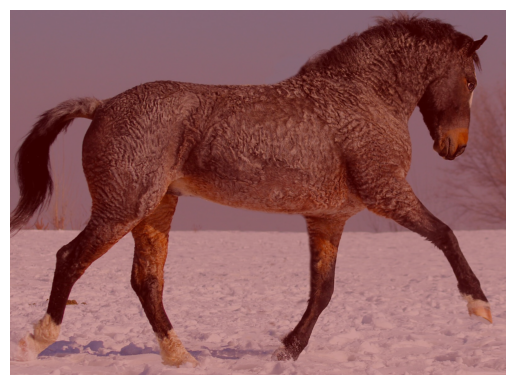

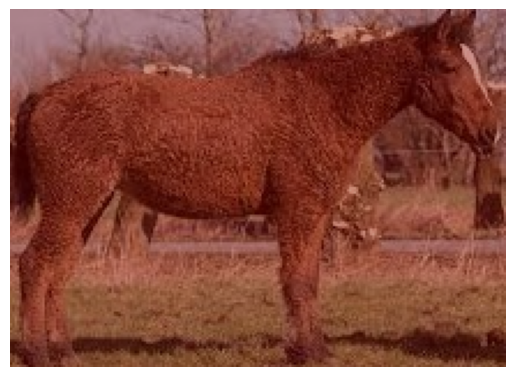

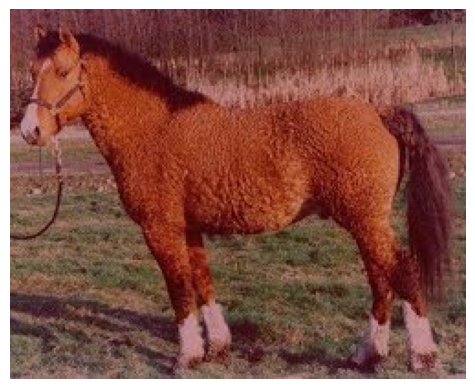

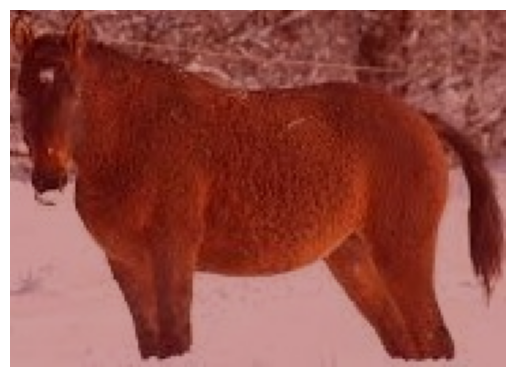

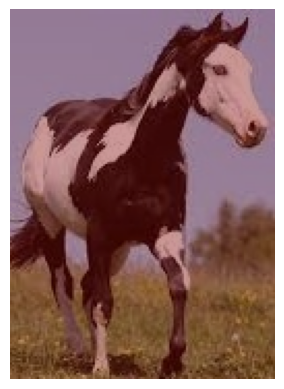

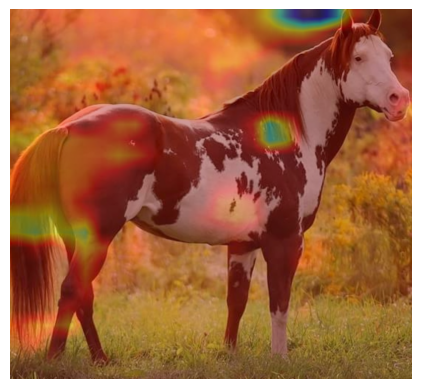

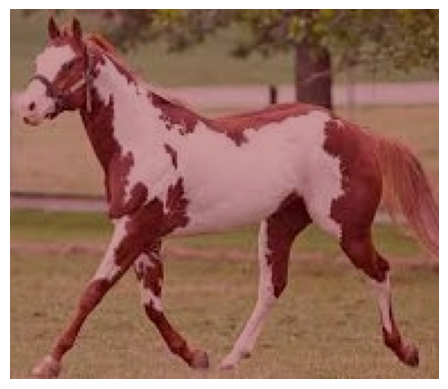

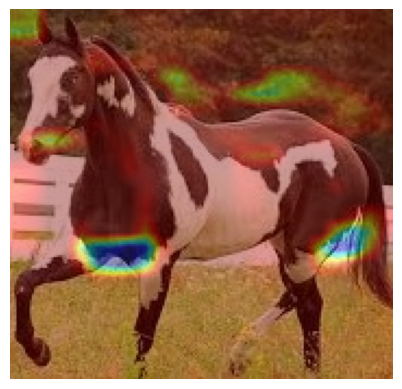

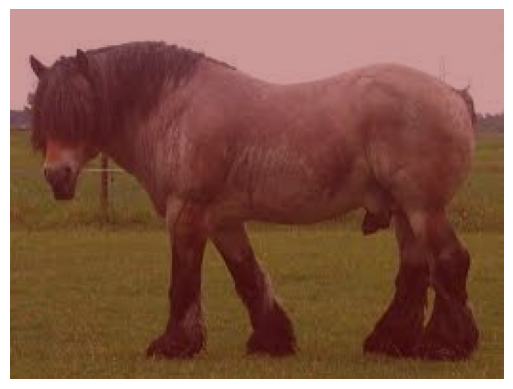

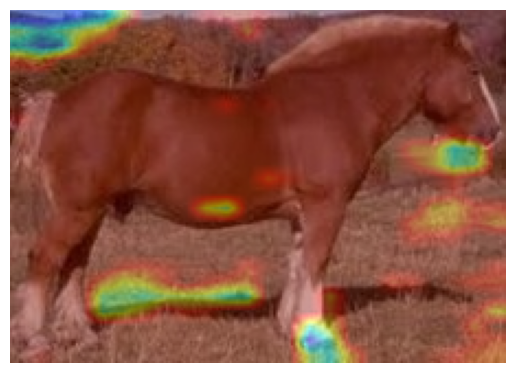

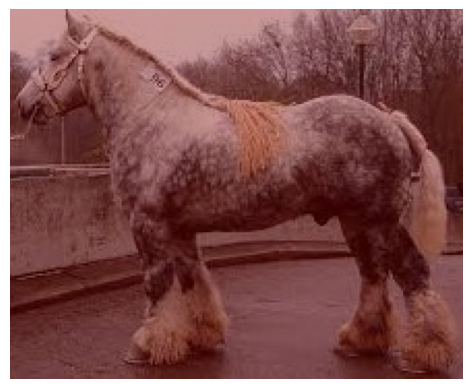

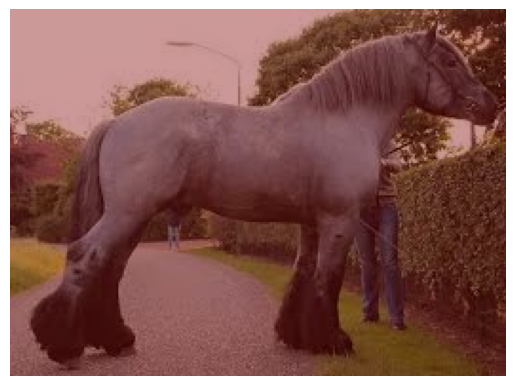

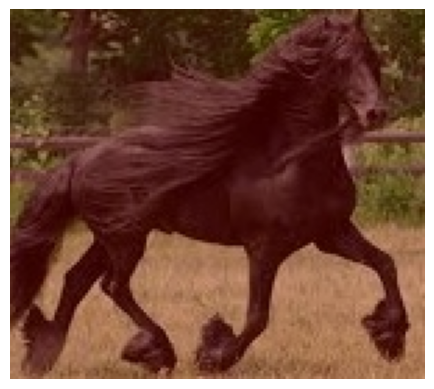

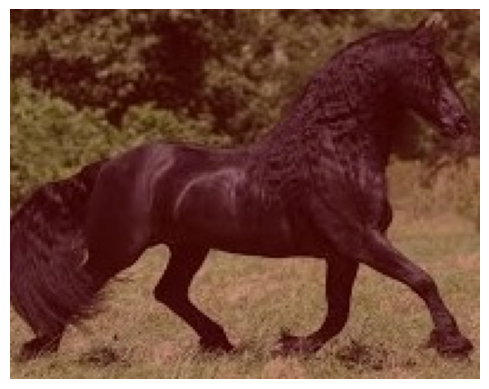

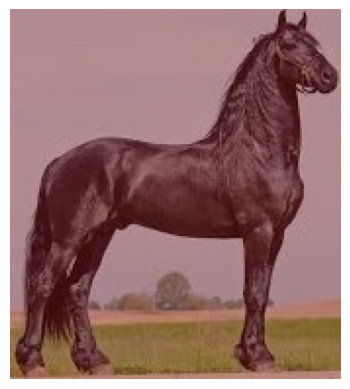

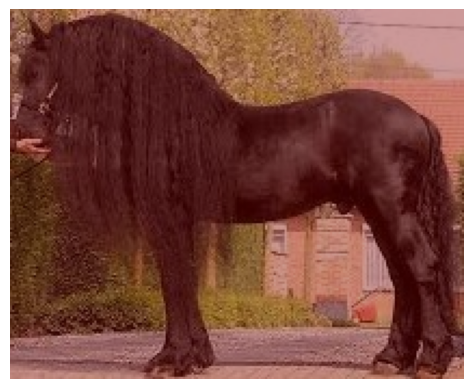

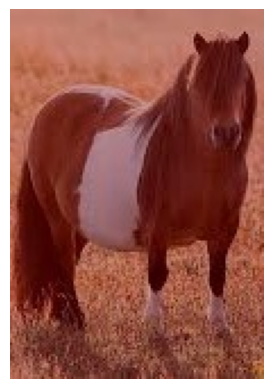

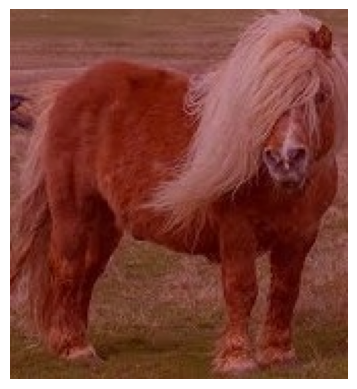

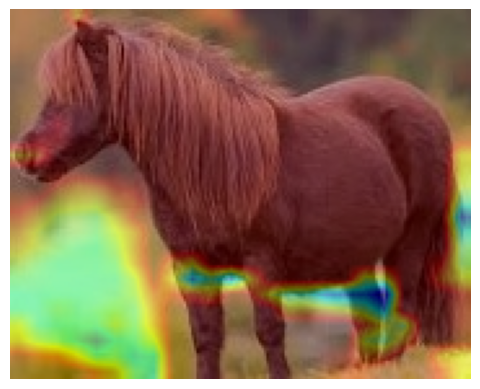

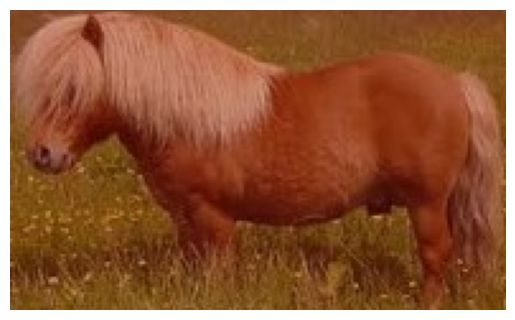

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image

# Define the functions for generating heatmap
def get_last_conv_layer_name(model):
    # Find the last convolutional layer
    for layer in reversed(model.layers):
        if 'conv' in layer.name:
            return layer.name
    raise ValueError("No convolutional layer found in the model.")

def get_heatmap(model, img_array, last_conv_layer_name):
    grad_model = Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        class_idx = tf.argmax(preds[0])
        class_output = preds[:, class_idx]

    grads = tape.gradient(class_output, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer_output), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    return heatmap.astype(np.float32)

def plot_heatmap(img_path, heatmap):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Convert BGR to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Apply heatmap as an overlay
    superimposed_img = cv2.addWeighted(img_rgb, 0.6, heatmap, 0.4, 0)

    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

# Load the saved model for inference
model = tf.keras.models.load_model('models/horses2.h5')

# Inference on new images
image_folder = './inferencing - Copy'
image_files = os.listdir(image_folder)

preprocessed_images = []
for img_file in image_files:
    img_path = os.path.join(image_folder, img_file)
    img = image.load_img(img_path, target_size=(224, 224))  # Ensure target size matches your model's input size
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    preprocessed_images.append(img_array)

# Display predictions with heatmap
for i, img_file in enumerate(image_files):
    img_path = os.path.join(image_folder, img_file)
    last_conv_layer_name = get_last_conv_layer_name(model)
    heatmap = get_heatmap(model, preprocessed_images[i], last_conv_layer_name)
    plot_heatmap(img_path, heatmap)